In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import AdamW
from neurovlm.data import data_dir
from neurovlm.train import Trainer, which_device
from neurovlm.models import TextAligner
from neurovlm.loss import InfoNCELoss
device = which_device()

# Projection Head

Projection head refers to a small network to align the latent spaces between text and neuroimages. The training regime starts with MSELoss, then gradually removed the influences of outliers through truncation, i.e. masking out the top-k% of loss instances from gradient computation.

In [2]:
# Load autoencoder
autoencoder = torch.load(data_dir / "autoencoder.pt", weights_only=False)

# Load vectors from 01_coordinate.ipynb
neuro_vectors, pmids = torch.load(
    data_dir / "neuro_vectors_difumo_proj.pt", weights_only=False,
).values()

# Load splits
ids_train, ids_test, ids_val = torch.load(
    data_dir / "pmids_split.pt", weights_only=False, map_location="cpu"
).values()

# Load encoded neuroimagesb from 08_autoencoder.ipynb
latent_neuro, pmids_latent = torch.load(
    data_dir / "latent_neuro.pt", weights_only=False, map_location="cpu"
).values()

# Load encoded text from 02_pubmned.ipynb
latent_text_specter, pmids_specter = torch.load(
    data_dir / f"latent_specter2_adhoc.pt", weights_only=False, map_location="cpu"
).values()

In [3]:
# Reduce to instances with <= 100 coordinates
mask = pd.Series(pmids).isin(pmids_latent)
neuro_vectors = neuro_vectors[mask]
pmids = pmids[mask]
assert (pmids == pmids_latent).all()

mask = pd.Series(pmids_specter).isin(pmids_latent)
latent_text_specter = latent_text_specter[mask]
pmids_specter = pmids_specter[mask]
assert (pmids == pmids_specter).all()

train_mask = pmids.isin(ids_train)
val_mask = pmids.isin(ids_val)
test_mask = pmids.isin(ids_test)

X_train  = latent_text_specter[train_mask]
X_test  = latent_text_specter[test_mask]
X_val  = latent_text_specter[val_mask]

y_train = neuro_vectors[train_mask]
y_test = neuro_vectors[test_mask]
y_val = neuro_vectors[val_mask]

## MSE

In [4]:
class ProjHead(nn.Module):
    def __init__(self, base, decoder):
        super().__init__()
        self.base = base
        self.decoder = decoder
        for p in self.decoder.parameters():
            p.requires_grad_(False)
    def forward(self, X):
        return self.decoder(self.base(X))

proj_head = ProjHead(
    TextAligner(seed=123, latent_text_dim=768, hidden_dim=512, latent_neuro_dim=384),
    autoencoder.decoder
)

trainer_specter = Trainer(
    proj_head,
    batch_size=512,
    n_epochs=201,
    lr=2e-5,
    loss_fn=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.AdamW,
    X_val=X_val,
    y_val=y_val,
    device="auto",
    interval=20,
)

trainer_specter.fit(X_train, y_train)

proj_head = trainer_specter.model.base

# Save
torch.save(proj_head, data_dir / f"proj_head_mse.pt")

Epoch: -1, val loss: 0.65938
Epoch: 0, val loss: 0.64723
Epoch: 20, val loss: 0.38868
Epoch: 40, val loss: 0.37882
Epoch: 60, val loss: 0.37429
Epoch: 80, val loss: 0.37137
Epoch: 100, val loss: 0.36956
Epoch: 120, val loss: 0.36836
Epoch: 140, val loss: 0.36754
Epoch: 160, val loss: 0.36692
Epoch: 180, val loss: 0.36644
Epoch: 200, val loss: 0.36604


## Contrastive Loss

In [18]:
proj_head = torch.load(data_dir / f"proj_head_mse.pt", weights_only=False)

# Split data
X_train_image = latent_neuro[train_mask].to(device)
X_train_text  = latent_text_specter[train_mask].to(device)
X_val_image = latent_neuro[val_mask].to(device)
X_val_text  = latent_text_specter[val_mask].to(device)

# Models
proj_head_text  = proj_head.to(device) # initialize with the decoder model
proj_head_image = TextAligner(
    seed=123, latent_text_dim=384, hidden_dim=384, latent_neuro_dim=384
).to(device)

# Settings
loss_fn = InfoNCELoss(temperature=0.2)
n_epochs = 501
batch_size = 2048
lr = 2e-5
optimizer = AdamW([*proj_head_text.parameters(), *proj_head_image.parameters()], lr=lr)
interval = 50

# Train
iterable = tqdm(range(n_epochs), total=n_epochs)

for iepoch in iterable:

    proj_head_text.train()
    proj_head_image.train()

    # Randomly shuffle and batch
    torch.manual_seed(iepoch)
    rand_inds = torch.randperm(len(X_train_image), device=device)

    for i in range(0, len(X_train_image), batch_size):
        idx = rand_inds[i:i+batch_size]

        # Forward
        y_text  = proj_head_text(X_train_text[idx])
        y_image = proj_head_image(X_train_image[idx])

        # Loss
        loss = loss_fn(y_text, y_image)

        # Backward
        optimizer.zero_grad(set_to_none=True)
        loss.backward()

        # Step
        optimizer.step()

    # Report validation
    if iepoch % interval == 0 or iepoch == (n_epochs - 1):
        proj_head_text.eval()
        proj_head_image.eval()
        with torch.no_grad():
            y_text  = proj_head_text(X_val_text)
            y_image = proj_head_image(X_val_image)
            val_loss = loss_fn(y_text, y_image)
            print(f"Epoch: {iepoch}, val loss: {float(val_loss):.5g}")


torch.save(proj_head_text, data_dir / "proj_head_text_infonce.pt")
torch.save(proj_head_image, data_dir / "proj_head_image_infonce.pt")

  0%|          | 0/501 [00:00<?, ?it/s]

Epoch: 0, val loss: 8.0012
Epoch: 50, val loss: 7.4632
Epoch: 100, val loss: 7.2989
Epoch: 150, val loss: 7.2431
Epoch: 200, val loss: 7.2045
Epoch: 250, val loss: 7.1747
Epoch: 300, val loss: 7.152
Epoch: 350, val loss: 7.1345
Epoch: 400, val loss: 7.1203
Epoch: 450, val loss: 7.1097
Epoch: 500, val loss: 7.099


## Example Predictions

In [23]:
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.plotting import plot_glass_brain
from neurovlm.models import Specter

# Load models
decoder = autoencoder.decoder.to("cpu")
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")
proj_head = torch.load(data_dir / f"proj_head_mse.pt", weights_only=False)

There are adapters available but none are activated for the forward pass.


In [24]:
queries = [
    # Regions
    "visual cortex",
    "motor cortex",
    "temporal lobe",
    "cerebellum",
    "precuneus",
    "hippocampus",
    # Neurotransmitters
    "dopamine",
    "serotonin",
    "gaba",
    "norepinephrine",
    # Networks
    "default mode network",
    "salience network",
    "executive control network",
    "sensorimotor network",
    # Cognitiion
    "working memory",
    "episodic memory",
    "executive function",
    "emotion regulation",
    "attention",
    "language processing",
    "cognitive control",
    "reward processing",
]

  0%|          | 0/22 [00:00<?, ?it/s]

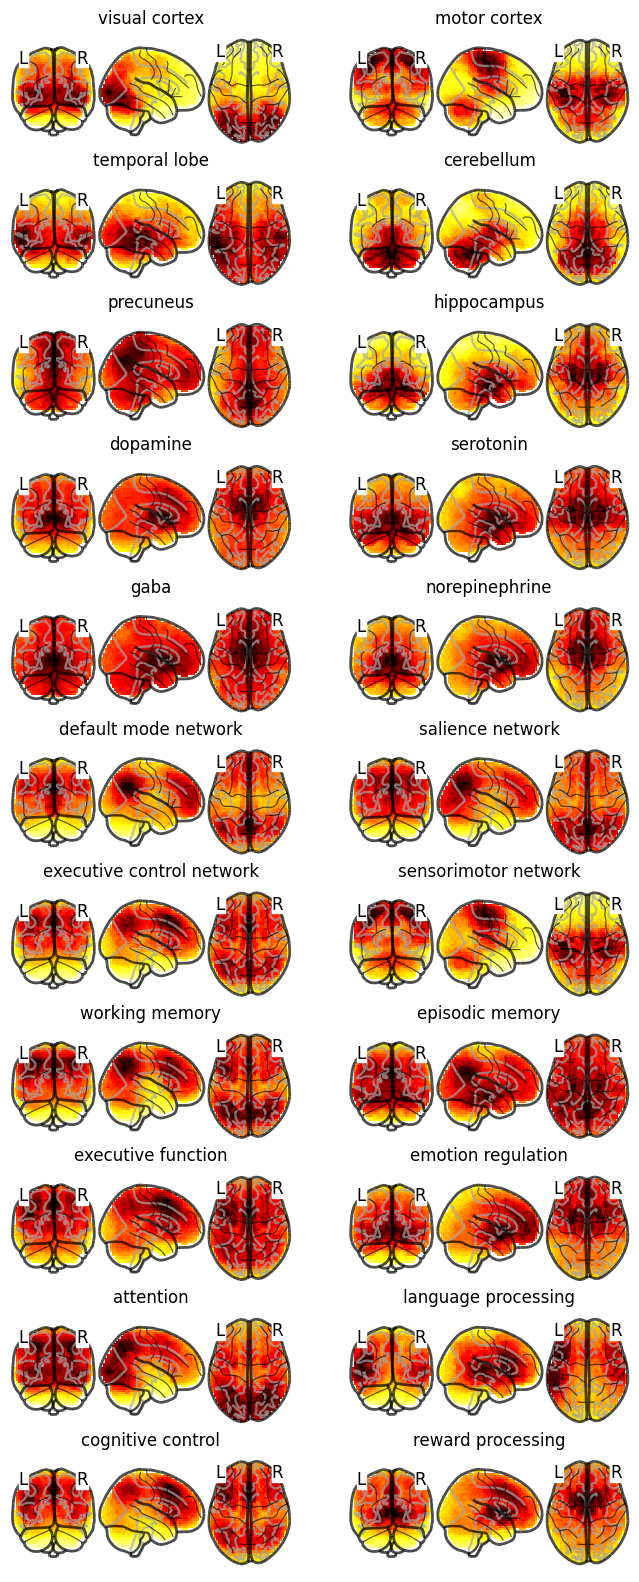

In [25]:
# Load mask
mask_arrays = np.load(f"{data_dir}/mask.npz", allow_pickle=True)
mask = mask_arrays["mask"]
affine = mask_arrays["affine"]

# Query
decoder = autoencoder.decoder.to("cpu")

fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(8, 20))
axes = axes.flatten()

for i, query in tqdm(enumerate(queries), total=len(queries)):

    # Encode text
    encoded_text_specter = specter(query)
    encoded_text_specter = encoded_text_specter / encoded_text_specter.norm()

    # Projection head
    aligned_text_specter = proj_head.to("cpu")(encoded_text_specter)

    # Decode brain
    neuro_pred = torch.sigmoid(decoder(aligned_text_specter)).detach().numpy()[0]

    # # Plot
    pred = np.zeros(mask.shape)
    pred[mask] = neuro_pred
    img = nib.Nifti1Image(pred, affine)
    plot_glass_brain(img, threshold=0, axes=axes[i], colorbar=False, resampling_interpolation="nearest")
    axes[i].set_title(query)